In [3]:
import os
import numpy as np
import pandas
import os
import skimage
from scipy import ndimage, signal
from skimage import exposure
import matplotlib.pyplot as plt
import glob
from skimage import io
import scipy
from scipy import signal
from skimage import feature
from tqdm import tqdm_notebook as tqdm
import json
from matplotlib_scalebar.scalebar import ScaleBar
import networkx as nx
import timeit
import re
import sys

import matplotlib.pyplot as plt
import networkx as nx
import pandas


# Homebrewed packages

import plotting_tools

## Graph analysis

In [5]:
IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\\'
df1 = pandas.read_csv(IntensityPath + 'intensityFrame_01_01.csv')

from sklearn.preprocessing import StandardScaler

X = df1[['Green', 'Orange']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

df1['Green Corr'] = X[:,0]
df1['Orange Corr'] = X[:,1]

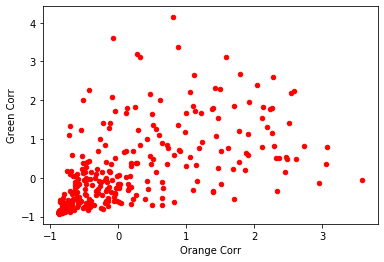

In [6]:
import matplotlib.pyplot as plt

ax1 = df1.plot.scatter(x='Orange Corr',y='Green Corr', c= 'r')

Text(0.5, 1.0, 'Gaussian Mixture')

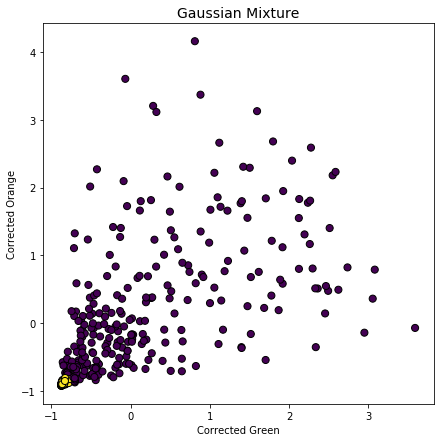

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture


gmm =  mixture.GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)
fig, ax = plt.subplots(1, figsize=(7,7))
ax.scatter(df1['Orange Corr'],df1['Green Corr'],
          c=labels.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("Corrected Green")
ax.set_ylabel("Corrected Orange")
plt.title("Gaussian Mixture", fontsize=14)

Text(0.5, 1.0, 'Gaussian Mixture')

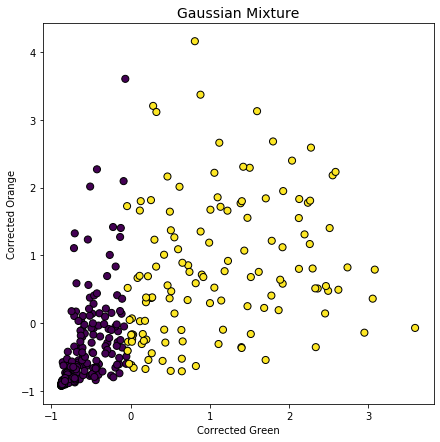

In [12]:
X = df1[['Orange']]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
km = KMeans(n_clusters=2)
km.fit(X)
km.predict(X)
labels = km.labels_
gmm =  mixture.GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)

fig, ax = plt.subplots(1, figsize=(7,7))
ax.scatter(df1['Orange Corr'],df1['Green Corr'],
          c=labels.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("Corrected Green")
ax.set_ylabel("Corrected Orange")
plt.title("Gaussian Mixture", fontsize=14)

In [21]:
IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\\'

import json

with open(IntensityPath + 'spheroid_01_01.json') as json_file:
    data = json.load(json_file)
    
FigureFrame = pandas.DataFrame()
j = 0

for cell in data['cells'].keys():
    
    loc = data['cells'][cell]
    
    FigureFrame.loc[j, 'x'] = loc['x']
    FigureFrame.loc[j, 'y'] = loc['y']
    FigureFrame.loc[j, 'color'] = loc['state GMM']
    
    j += 1
    
FigureFrame['x'] = pandas.to_numeric(FigureFrame['x'])
FigureFrame['y'] = pandas.to_numeric(FigureFrame['y'])
FigureFrame['label'] = (FigureFrame['color'] == 'Green').astype('int')

In [22]:
import spheroid

path = r'\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\01\06\cropStack'


livePosition = 2
green = 0
orange = 1

channels = [livePosition, green, orange]

zRatio = 1
r = 8
d = 20
pxtoum = 2/3

dX = 2*(int(r/pxtoum)//2)+1
dY = 2*(int(r/pxtoum)//2)+1
dZ = 2*(int(zRatio*r/pxtoum)//2)+1

rNoyau = (dZ, dX, dY)

dX = 2*(int(d/pxtoum)//2)+1
dY = 2*(int(d/pxtoum)//2)+1
dZ = 2*(int(zRatio*d/pxtoum)//2)+1

dCells = (dZ, dX, dY)

minmass = 5000

Sph = spheroid.spheroid(path, '01', '04', zRatio, r, d,pxtoum, minmass)
    # Initialize spheroid

if len(channels) == 3: # Improve dependancy on channel number...

    Sph._loadImage(channels[0], 'NucImage') # Load live cells
    Sph._loadImage(channels[1], 'GreenImage') # Load green cells
    Sph._loadImage(channels[2], 'OrangeImage') # Load orange cells

else: print("Wrong number of color channels")

print('image made, starting nuclei ID')

image made, starting nuclei ID


C:\Users\gronteix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


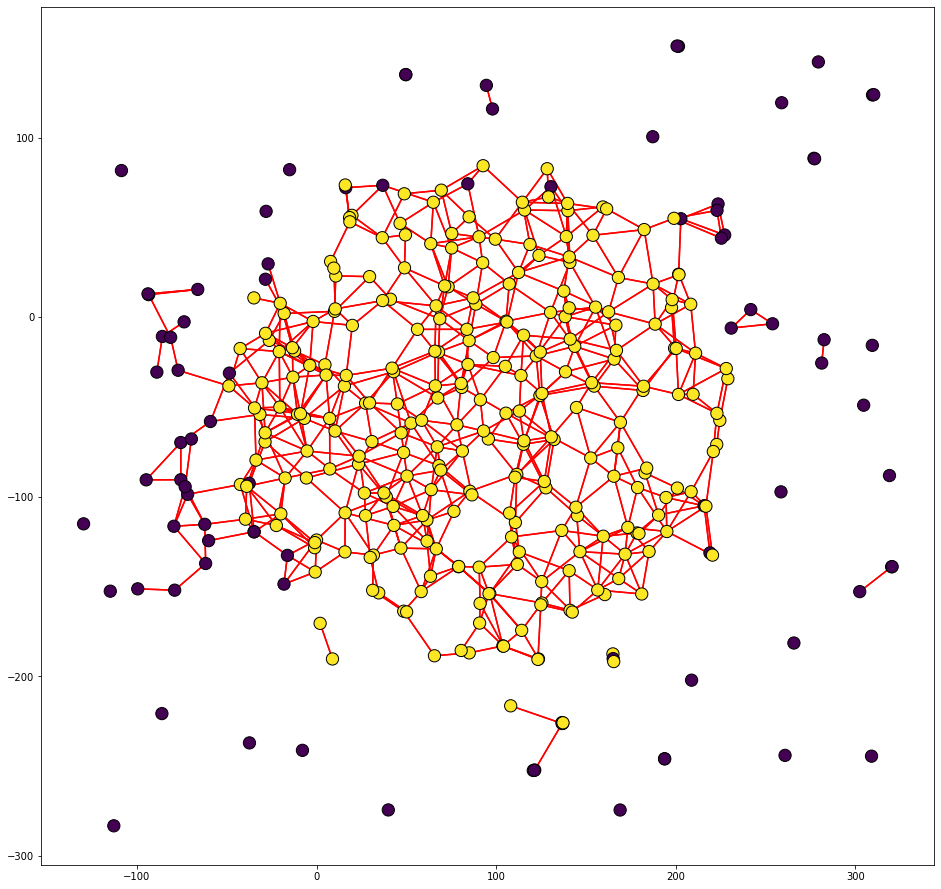

In [24]:
from scipy.ndimage import gaussian_filter

img_eq = exposure.equalize_hist(Sph.OrangeImage[65,350:1750,200:2000])
im =  gaussian_filter(img_eq, sigma=4)

fig, ax = plt.subplots(figsize = (16,16))

for cell in data['cells'].keys():
    
    loc = data['cells'][cell]
    
    for neigh in loc['neighbours']:
        
        x1 = float(loc['x'])-200
        x2 = float(data['cells'][neigh]['x'])-200
        y1 = float(loc['y'])-350
        y2 = float(data['cells'][neigh]['y'])-350
        
        plt.plot([x1,x2], [y1,y2], 'r-', zorder = 1)
        
plt.imshow(im[:-250,:-250])
ax.scatter(FigureFrame['x']-200, FigureFrame['y']-350, c=FigureFrame['label'].astype(np.float), edgecolor="k", s=150, zorder=2)

In [15]:
def default(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError

IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\\'

import json

for fileName in glob.glob(IntensityPath + '*.json')[1:]:
    
    print(fileName)
    
    with open(fileName) as json_file:
        data = json.load(json_file)
        
    # Extract the intensities

    ClassFrame = pandas.DataFrame()
    j = 0

    for cell in data['cells'].keys():

        loc = data['cells'][cell]

        ClassFrame.loc[j, 'particle'] = cell
        ClassFrame.loc[j, 'Green'] = loc['Intensity Green']
        ClassFrame.loc[j, 'Orange'] = loc['Intensity Orange']

        j += 1

    X = ClassFrame[['Green']]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    gmm =  mixture.GaussianMixture(n_components=2).fit(X)
    labels = gmm.predict(X)

    ClassFrame['labels'] = labels
    
    a = ClassFrame.loc[ClassFrame['Green'] == ClassFrame['Green'].max(), 'labels'].iloc[0]
    
    if a < 0:
        
        ClassFrame['labels'] *= -1

    for part in ClassFrame['particle'].unique():

        data['cells'][str(part)]['state GMM postprocess'] = 2*ClassFrame.loc[ClassFrame['particle'] == part, 'labels'].iloc[0]-1
        
    with open(fileName, 'w') as fp:

        json.dump(data, fp, default = default)

\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_02.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_03.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_04.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_05.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_06.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_07.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_08.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_01_09.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_02_01.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_02_02.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmix\Spheroids\spheroid_02_03.json
\\atlas.pasteur.fr\Multicell\Gustave\20191106\directmi

In [16]:
IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\\'

import json

ClassFrame = pandas.DataFrame()
j = 0

for fileName in glob.glob(IntensityPath + '*.json')[1:]:
    
    _, sph, time = fileName.split('_')
    time, _ = time.split('.')
    
    print(fileName)
    
    with open(fileName) as json_file:
        data = json.load(json_file)
        
    try:
        
        for cell in data['cells'].keys():

            nCross = 0
            nSelf = 0

            loc = data['cells'][cell]
        
        
            si = loc['state GMM postprocess']

            for neigh in loc['neighbours']:
                sj = data['cells'][neigh]['state GMM postprocess']

                if sj*si < 0:

                    nCross += 1

                if sj*si > 0 :

                    nSelf += 1

            ClassFrame.loc[j, 'time'] = time
            ClassFrame.loc[j, 'spheroid'] = sph
            ClassFrame.loc[j, 'particle'] = cell
            ClassFrame.loc[j, 'state'] = si
            ClassFrame.loc[j, 'neighbours'] = nCross + nSelf
            ClassFrame.loc[j, 'cross link'] = nCross
            ClassFrame.loc[j, 'self link'] = nSelf
            j += 1
            
    except: print(fileName)

\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_1_2.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_1_22.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_1_5.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_2_19.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_2_2.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_2_22.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_2_5.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_3_19.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_3_2.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_3_22.json
\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\Spheroids\spheroid_3_5.json
\\atlas.pasteur.fr\Multicel

In [17]:
ResultFrame = pandas.DataFrame()
i = 0

for sph in ClassFrame['spheroid'].unique():
    for time in ClassFrame.loc[ClassFrame['spheroid'] == sph, 'time'].unique():
        
        locFrame = ClassFrame.loc[(ClassFrame['spheroid'] == sph) &
                                 (ClassFrame['time'] == time)]
        
        ResultFrame.loc[i, 'spheroid'] = sph
        ResultFrame.loc[i, 'time'] = int(time)
        ResultFrame.loc[i, 'degree'] = locFrame['neighbours'].mean()
        ResultFrame.loc[i, 'degree -1'] = locFrame.loc[locFrame['state'] == -1, 'neighbours'].mean()
        ResultFrame.loc[i, 'degree 1'] = locFrame.loc[locFrame['state'] == 1, 'neighbours'].mean()
        ResultFrame.loc[i, 'p(cross|s = 1)'] = locFrame.loc[locFrame['state'] == 1, 
                'cross link'].sum()/locFrame.loc[locFrame['state'] == 1, 'neighbours'].sum()
        ResultFrame.loc[i, 'p(cross|s = -1)'] = locFrame.loc[locFrame['state'] == -1, 
                'cross link'].sum()/locFrame.loc[locFrame['state'] == -1, 'neighbours'].sum()
        i += 1

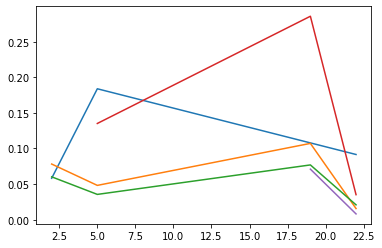

In [18]:
plt.figure()

for sph in ResultFrame['spheroid'].unique():
    
    locFrame = ResultFrame.loc[ResultFrame['spheroid'] == sph].sort_values('time')
    
    plt.plot(locFrame['time'], locFrame['p(cross|s = -1)'])

In [ ]:
import collections

In [14]:
df = pandas.DataFrame()
i = 0
    
for fileName in glob.glob(IntensityPath + r'\\' + '*.json'):
    
    with open(dicName, "r") as read_file:
        _Sph = json.load(read_file)
        
    for key in _Sph['cells'].keys():
        
        df.loc[i, 'name'] = fileName
        df.loc[i, 'degree'] = _Sph['cells'][key]['degree']
        df.loc[i, 'clustering'] = _Sph['cells'][key]['clustering']
        df.loc[i, 'centrality'] = _Sph['cells'][key]['centrality']
        df.loc[i, 'state'] = _Sph['cells'][key]['state']
        i += 1

NameError: name 'dicName' is not defined

In [ ]:
plt.scatter(np.log(df['clustering']), np.log(df['degree']))

In [ ]:
n, bins, patches = plt.hist(df['centrality'].values, 15, normed=1, facecolor='green', alpha=0.75)

In [ ]:
%matplotlib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['z'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim(0,51)

plt.show()


from matplotlib_scalebar.scalebar import ScaleBar

for n in range(len(mask_img)):

    plt.subplot(111)
    plt.imshow(mask_img[n], cmap=plt.cm.gray, alpha = 0.8)
    plt.axis('off')
    
    scalebar = ScaleBar(0.000001, location = 'lower right') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)

    lf = df.loc[df['z'] == n]
    mf = df.loc[df['z'] == n-1]
    pf = df.loc[df['z'] == n+1]

    plt.plot(mf['y'], mf['x'], 'go', label = 'z = ' + str(n-1))
    plt.plot(lf['y'], lf['x'], 'yo', label = 'z = ' + str(n))
    plt.plot(pf['y'], pf['x'], 'ro', label = 'z = ' + str(n+1))

    plt.show()
    plt.legend()
    
    #plt.savefig(r'/Users/gustaveronteix/Desktop/Image Stack/filmstack/im_' + str(n) +'.png')
    plt.close()

In [92]:
_Cells = _NewSph['cells']
G = plotting_tools.generate_random_3Dgraph(_Cells, 1/5, 23, scale = 1/3, seed=None)

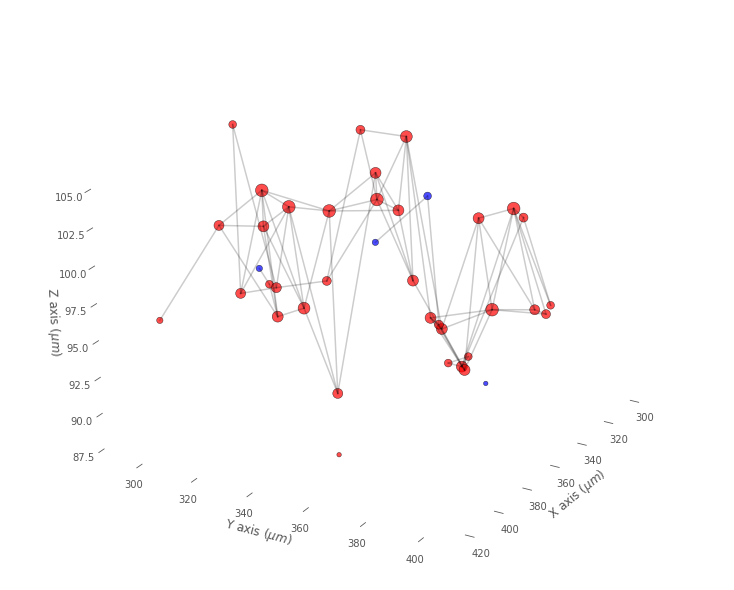

In [93]:
plotting_tools.classifier_plot_3D(G, 30, _NewSph, save=False)

#plt.savefig(path + '\\3D_00_00.png')
plt.show()

C:\Users\gronteix\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


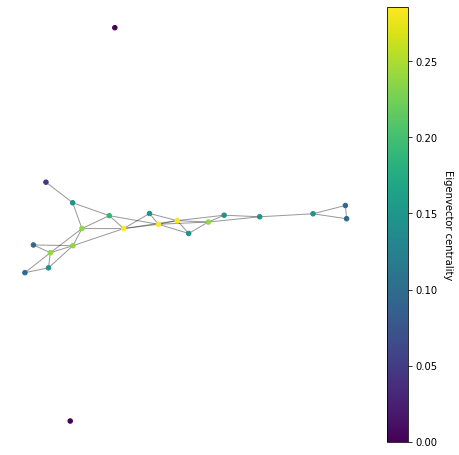

In [68]:
path = r'X:\Gustave\Experiments\Nuclei Segmentation\01072019\tif\\'
dicName = path + '\spheroid_00_00.json'

with open(dicName, "r") as read_file:
    _Sph = json.load(read_file)

import networkx as nx
G=nx.Graph()
_Cells = _Sph['cells']
G.add_nodes_from(_Cells.keys())
for key in _Cells.keys():
    
    neighbours = _Cells[key]['neighbours']
    
    for node in neighbours:
    
        G.add_edge(key, node)

centrality = []
eV = nx.degree_centrality(G)

import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

for key in _Cells.keys():
        
    centrality.append(eV[key])

plt.figure(figsize=(8, 8))

pos = nx.spring_layout(G)
im = nx.draw_networkx_nodes(G, pos, node_size=20, node_color = centrality, cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.4)

#legend
cbar = plt.colorbar(im)
cbar.set_label('Eigenvector centrality', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

plt.axis('off')
#plt.savefig(path + '\\fig_58_5.png')
plt.show()